In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [12]:
!pip install onnxmltools

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
class LogisticRegressionModel(torch.nn.Module):

    def __init__(self, input_dim, output_dim):

        # call class constructor
        super(LogisticRegressionModel, self).__init__()

        # use the nn package to create a linear layer
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):

        # First we pass the input through the linear layer,
        # then we pass that through sigmoid, which implements the logistic function.
        out = torch.sigmoid(self.linear(x)) 
        return out

In [14]:
def log_reg_fit(x, y, learning_rate, epochs):
    # Train a logistic regresson model using SGD and pytorch. 
    # Args:
    #    x - feature array, a numpy array
    #    y - response array, a numpy array
    #    learning_rate - learning rate used in SGD
    #    epochs - number of epochs for the SGD loop
    # Returns:
    #    The trained model

    # number of dimensions in incoming data
    input_dimension = x.ndim
    output_dimension = y.ndim

    # if the features are a 1-d array (a list), turn into a 2d column vector
    if input_dimension == 1:
        x = x[:, np.newaxis]
        input_size = 1
    else:
        input_size = x.shape[1]

    if output_dimension == 1:
        y = y[:, np.newaxis]
        output_size = 1
    else:
        output_size = y.shape[1]

    # initialize the model
    model = LogisticRegressionModel(input_size, output_size)

    # error/loss function
    criterion = torch.nn.BCELoss()

    # SGD optimizer
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # feature and response variables
        features = Variable(torch.from_numpy(x).float())
        labels = Variable(torch.from_numpy(y).float())

        # clear the gradients
        optimiser.zero_grad()

        # calculate predicted values
        predictions = model.forward(features)

        # calculate loss
        loss = criterion(predictions, labels)

        # calculate the derivative/gradient for each feature
        loss.backward()
        
        # based on the gradients, take a step in the right direction
        optimiser.step()

    return model

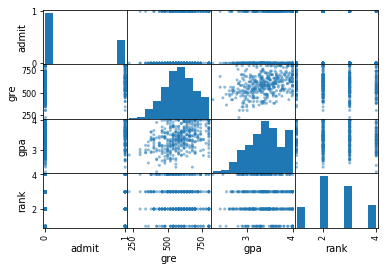

In [15]:
# import the loan data
df = pd.read_csv('s3://helen-ml/week-3/grad_school.csv')

_ = pd.plotting.scatter_matrix(df)

In [27]:
# split data into training and test sets
train, test = train_test_split(df, test_size=0.2)

columns = ['admit', 'gre', 'gpa', 'rank']
train_features = train.values[:, 1:3]
test_features = test.values[:, 1:3]

# train model
model = log_reg_fit(train_features, train['admit'].values, 0.1, 10000)

# make predictions on test data
raw_predictions = model(Variable(torch.from_numpy(test_features[:, np.newaxis]).float()))

# convert probability into discrete 1/0 predictions
predictions = []
for prediction in raw_predictions:
    if prediction.data.numpy()[0] > 0.50:
        predictions.append(1.0)
    else:
        predictions.append(0.0)

# calculate accuracy
acc = accuracy_score(test['admit'].values, predictions)
print('Accuracy: ', acc)

Accuracy:  0.6875
